<a href="https://colab.research.google.com/github/kenzfinn/csc1035_lecture_examples/blob/master/CSC3831_Part3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
from torchvision import datasets, transforms
import seaborn as sns

# standard practice
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# get CIFAR-10
dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)

train_size = int(0.8 * len(dataset)) #training is 80% of the dataser
val_size = len(dataset) - train_size #validation set is the rest
train_set, val_set = random_split(dataset, [train_size, val_size]) #splits them into validation adn training set
train_loader = DataLoader(train_set, batch_size=64, shuffle=True) #loads the training set to batches of 64
val_loader = DataLoader(val_set, batch_size=64, shuffle=False) #loads the validation set to batches of 64

100%|██████████| 170M/170M [00:03<00:00, 43.8MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [3]:
# https://pytorch.org/tutorials/beginner/knowledge_distillation_tutorial.html
# mainly based on deep neutral networks but helped
class CNNWithBN(nn.Module):
    def __init__(self):
        super(CNNWithBN, self).__init__()
        self.convl1 = nn.Conv2d(3, 32, 3,stride=1, padding=1)
        #input 3, output 32, 3 kernel size(stays the same)
        self.conv2 = nn.Conv2d(32, 64, 3,stride=1, padding=1)
        #input 32 output 64
        self.conv3 = nn.Conv2d(64, 128, 3, stride = 1, padding=1)
        #input 64 output 128
        self.fc1 = nn.Linear(2048, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        #reduces 2048 to the 10 classifiers
        #batch normalisation layers
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        #normilises based on the output of the conv layer before
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)



    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.convl1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))

        x = x.view(x.size(0), -1)
        #flat before FC

        # Fully connected layers
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)

        return x

class CNNWithoutBN(CNNWithBN):
    def __init__(self):
        super(CNNWithoutBN, self).__init__()
        #overwrites the batch normalisation in using the superclass
        self.bn1 = nn.Identity()
        self.bn2 = nn.Identity()
        self.bn3 = nn.Identity()
        #these overwrite the batch normalisation layers to just return the input

In [4]:
def train_model(model, train_loader, val_loader, epochs=50, patience=5):
    training_log = []
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True, weight_decay=5e-4)
    criterion = nn.CrossEntropyLoss()
    best_loss = float('inf')
    patience_counter = 0
    best_model = None
    #these all used for early stopping and best model

    for epoch in range(epochs):
        model.train()
        #train the model for each epoch
        train_loss = 0.0
        #resets training loss
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            #clears optimiser
            outputs = model(inputs)
            #computes outputs based on inputs with model
            loss = criterion(outputs, targets)
            #compares the output(predicions) to the target and uses the loss function to calculate loss
            loss.backward()
            optimizer.step()
            #goes backward then forwards to update parameters
            train_loss += loss.item()

        # Validation
        model.eval()
        #evaluates model
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
                #same as train_loss but parameters aren't updated due to the 'unseen' images

        print(f"Epoch {epoch+1} : Train Loss={train_loss/len(train_loader)}, Val Loss={val_loss/len(val_loader)}")
        epoch_data = {
        "epoch": epoch,
        "training_loss": train_loss/len(train_loader),
        "validation_loss": val_loss/len(val_loader)
        }
        training_log.append(epoch_data)
        #creates the epoch data dictionaries and adds to the list

        # early stopping occurs when validation loss doesn't change after a certain patience (numer of epochs)
        if val_loss < best_loss:
            best_loss = val_loss
            #initialised as infinity so first val_loss always 'best loss'
            best_model = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopp")
                break

    # Save the best model
    torch.save(best_model, 'best_model.pth')
    return best_model, training_log


In [5]:
model_with_bn = CNNWithBN()
model_without_bn = CNNWithoutBN()

import torch
if torch.cuda.is_available():
    print(f"CUDA is available. GPU name: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA is not available.")
# Train models one with batch normalisation one without,
# models also output epoch data used for convergence graphs so create list opbjects to store epoch dicts
bn_training_log = []
non_bn_training_log = []
best_model_bn, bn_training_log = train_model(model_with_bn, train_loader, val_loader)
#best_model_wo_bn, no_bn_training_log = train_model(model_without_bn, train_loader, val_loader)


CUDA is available. GPU name: Tesla T4
Epoch 1 : Train Loss=1.268388346672058, Val Loss=1.0637794812773442
Epoch 2 : Train Loss=0.8666890555381775, Val Loss=0.8984108529273113
Epoch 3 : Train Loss=0.7236638699054718, Val Loss=0.8047528741466012
Epoch 4 : Train Loss=0.6137677514076233, Val Loss=0.7243071369304779
Epoch 5 : Train Loss=0.522293579506874, Val Loss=0.7077674698677792
Epoch 6 : Train Loss=0.4514269945859909, Val Loss=0.7514085230553985
Epoch 7 : Train Loss=0.38209483840465547, Val Loss=0.6835343275859858
Epoch 8 : Train Loss=0.3254164050459862, Val Loss=0.6756531279178182
Epoch 9 : Train Loss=0.2688601746082306, Val Loss=0.7344763485869025
Epoch 10 : Train Loss=0.22608807894587518, Val Loss=0.7596059166322089
Epoch 11 : Train Loss=0.18682143043279648, Val Loss=0.7727694338673998
Epoch 12 : Train Loss=0.1591864679545164, Val Loss=0.772896413590498
Epoch 13 : Train Loss=0.12888883117437364, Val Loss=0.8357203822986335
Early stopp


In [ ]:
best_model_wo_bn, no_bn_training_log = train_model(model_without_bn, train_loader, val_loader)

KeyboardInterrupt: 

In [ ]:

epochs = [entry["epoch"] for entry in bn_training_log]
training_losses = [entry["training_loss"] for entry in bn_training_log]
validation_losses = [entry["validation_loss"] for entry in bn_training_log]

# Plot the losses
plt.plot(epochs, training_losses, label="Training Loss", marker='o', color='blue')
plt.plot(epochs, validation_losses, label="Validation Loss", marker='o', color='orange')

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss in CNN with batch normalisation")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
epochs = [entry["epoch"] for entry in no_bn_training_log]
training_losses = [entry["training_loss"] for entry in no_bn_training_log]
validation_losses = [entry["validation_loss"] for entry in no_bn_training_log]

# Plot the losses
plt.plot(epochs, training_losses, label="Training Loss", marker='o', color='blue')
plt.plot(epochs, validation_losses, label="Validation Loss", marker='o', color='orange')

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss in CNN without batch normalisation")
plt.legend()
plt.grid(True)
plt.show()

filters for the first conv layer


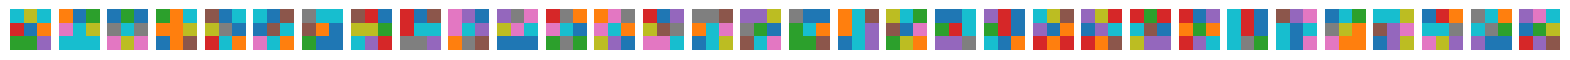

filters for second conv layer


<ipython-input-16-e20421b204f4>:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


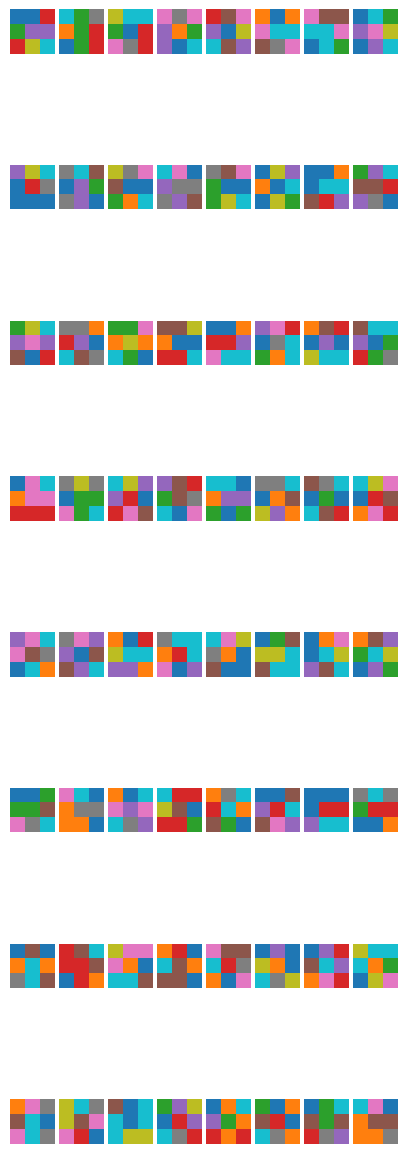

filters for third conv layer


<ipython-input-16-e20421b204f4>:74: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


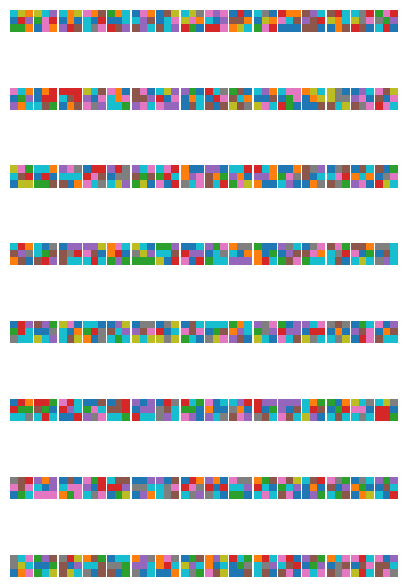

In [16]:
# https://machinelearningmastery.com/how-to-visualize-filters-and-feature-maps-in-convolutional-neural-networks/
# This was used to further my understand for the third part of the coursework

from matplotlib import pyplot

model = model_with_bn


first_layer = list(model.children())[0]  #
filters = first_layer.weight.data.cpu().numpy()
biases = first_layer.bias.data.cpu().numpy()
out_channels, in_channels, height, width = filters.shape
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
print('filters for the first conv layer')
fig, axes = plt.subplots(1, out_channels, figsize=(20, 5))
for i, ax in enumerate(axes):

    ax.imshow(filters[i, 0, :, :], cmap='tab10')
    ax.axis('off')

plt.show()

second_layer = list(model.children())[1]
filters = second_layer.weight.data.cpu().numpy()
biases = second_layer.bias.data.cpu().numpy()
out_channels, in_channels, height, width = filters.shape
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
print('filters for second conv layer')
num_cols = 8
num_rows = (out_channels + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(5, 2 * num_rows), gridspec_kw={'wspace': 0.1, 'hspace': 0.1})
axes = axes.flatten()
for i in range(out_channels):
    ax = axes[i]
    ax.imshow(filters[i, 0, :, :], cmap='tab10')
    ax.axis('off')


for i in range(out_channels, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

third_layer = list(model.children())[2]
filters = third_layer.weight.data.cpu().numpy()
biases = third_layer.bias.data.cpu().numpy()
out_channels, in_channels, height, width = filters.shape
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
print('filters for third conv layer')
num_cols = 16
num_rows = (out_channels + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(5,  num_rows), gridspec_kw={'wspace': 0.1, 'hspace': 0.1})
axes = axes.flatten()
for i in range(out_channels):
    ax = axes[i]
    ax.imshow(filters[i, 0, :, :], cmap='tab10')
    ax.axis('off')


for i in range(out_channels, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

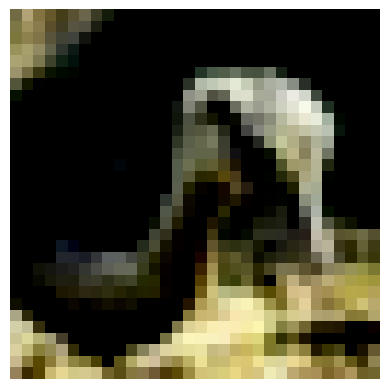

<ipython-input-32-e10487843682>:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


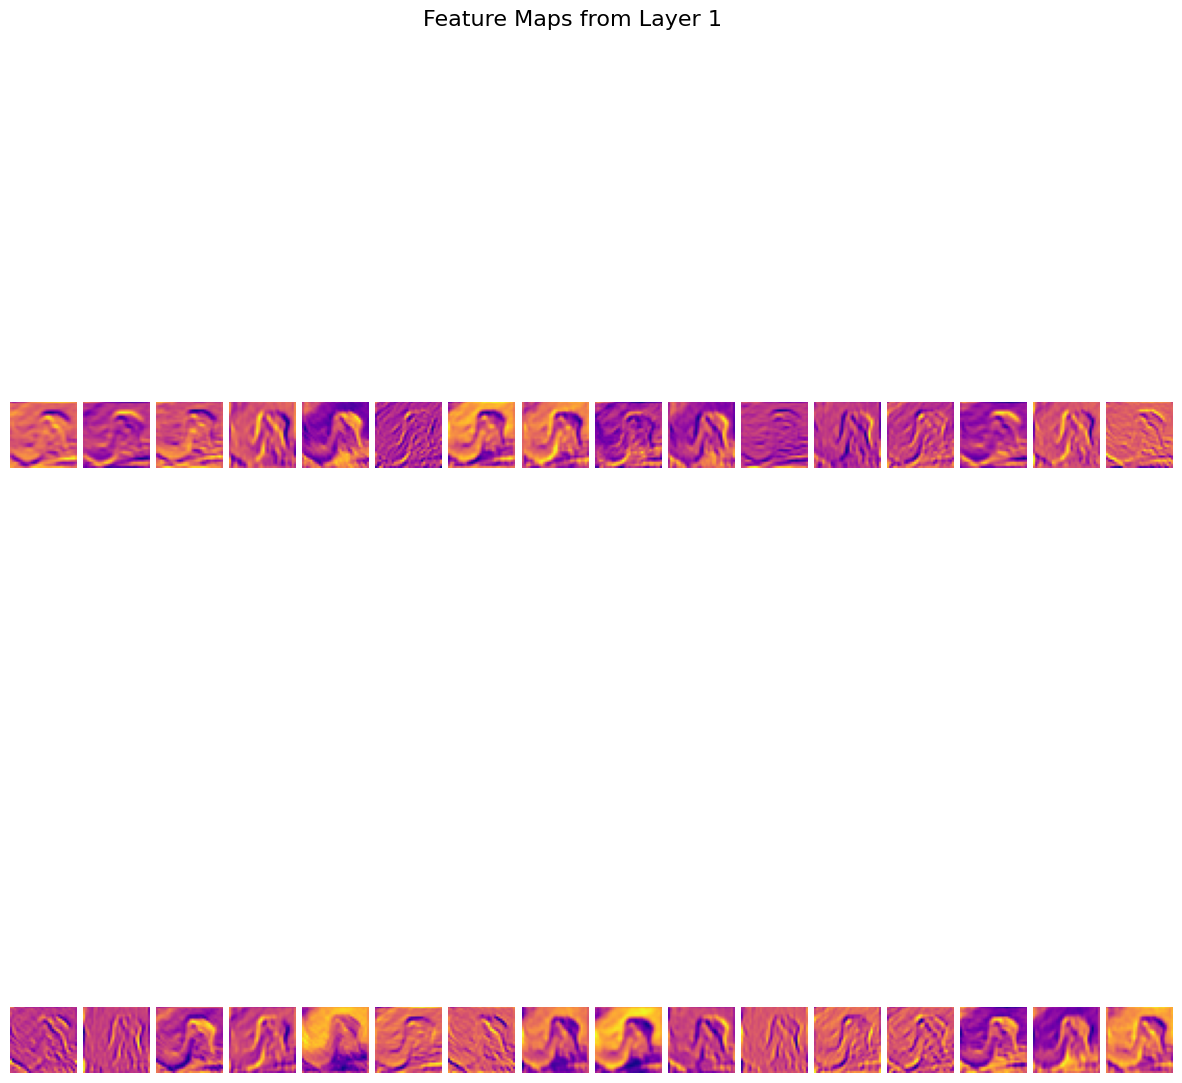

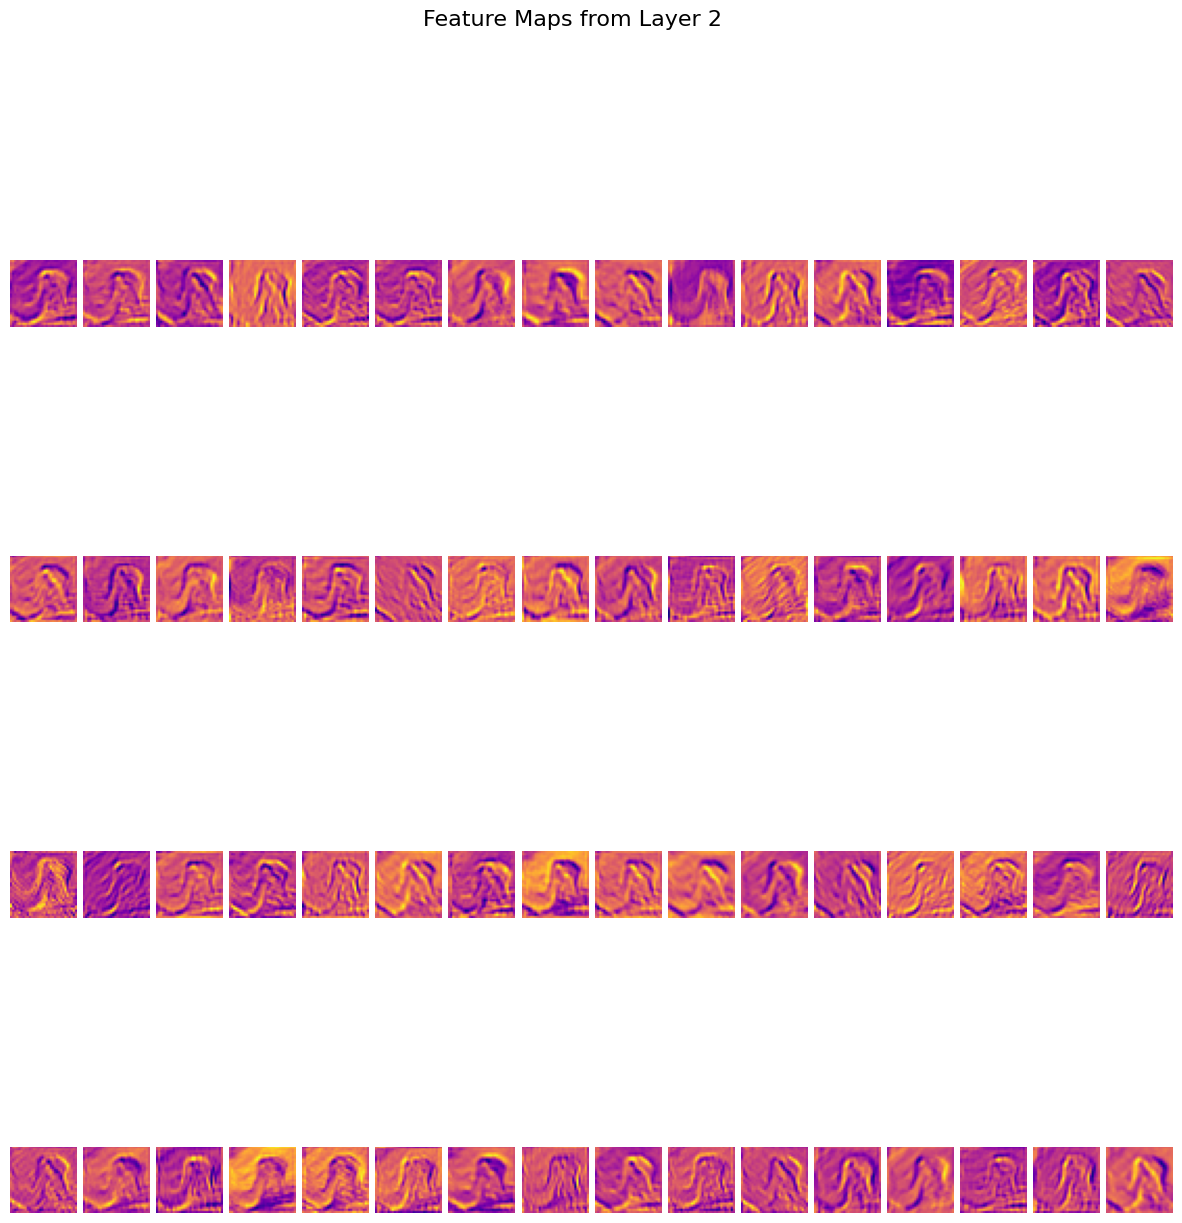

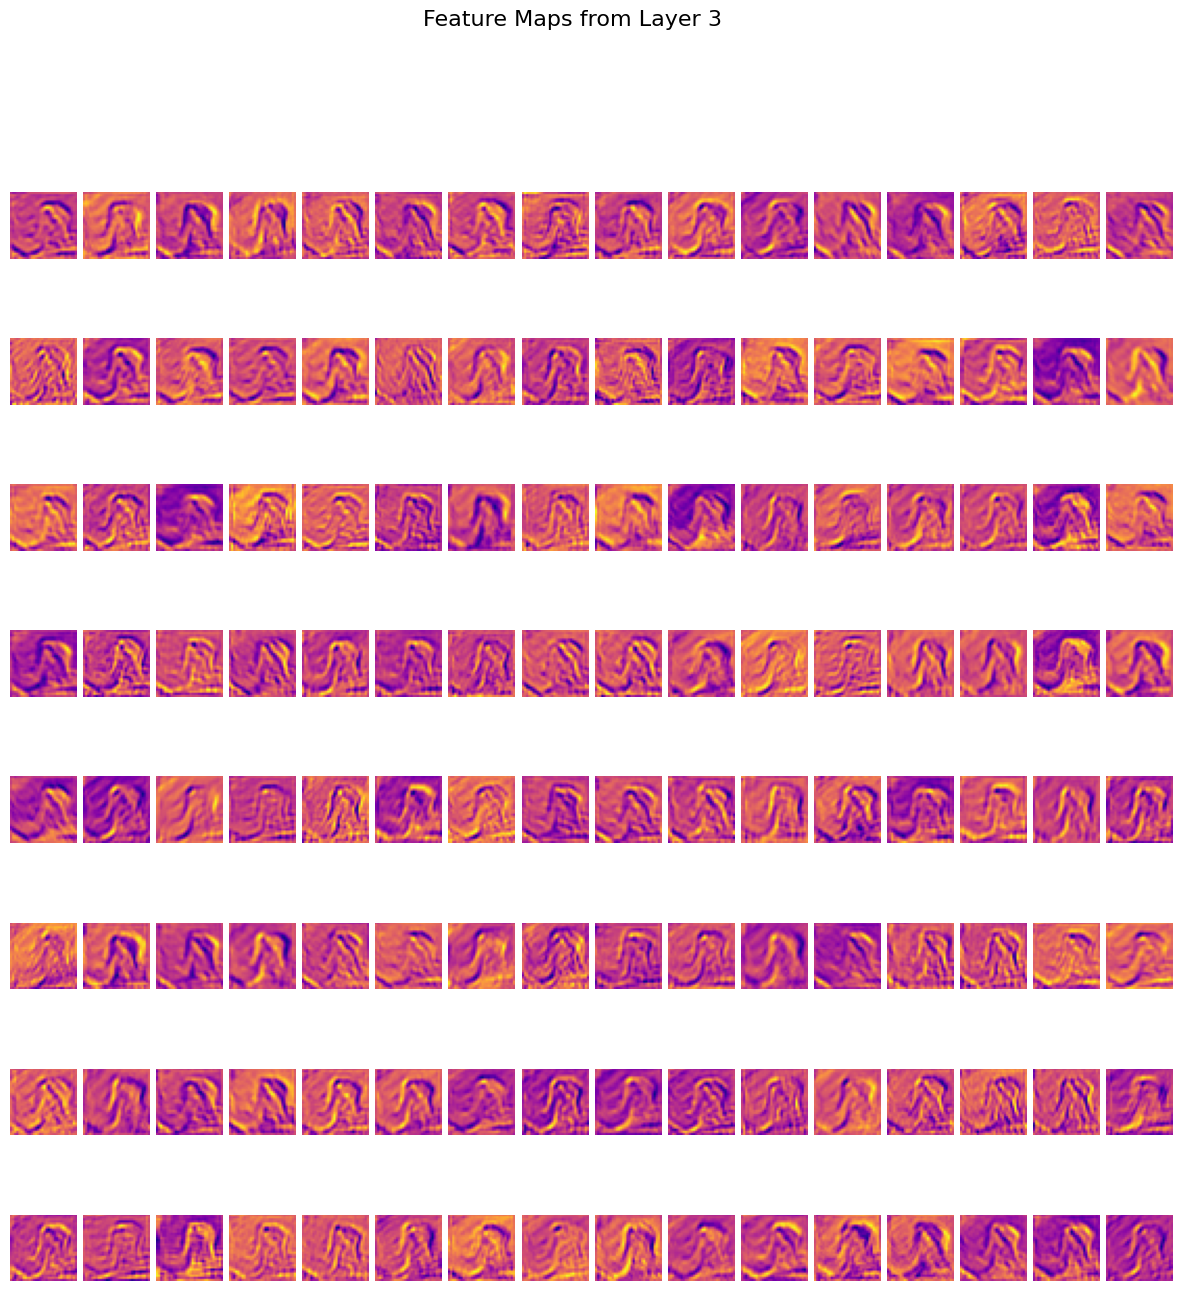

In [32]:
# https://pytorch.org/docs/stable/torch.html
# https://pytorch.org/tutorials/beginner/knowledge_distillation_tutorial.html

def visualize_conv_features(model, image, layers):
    image = image.unsqueeze(0)

    outputs = []
    x = image
    for layer in layers:
        x = layer(x)
        outputs.append(x)

    for idx, feature_map in enumerate(outputs):
        feature_map = feature_map.squeeze(0).detach().cpu().numpy()
        num_features = feature_map.shape[0]
        num_cols = 16
        # 16 good for viewing all easier
        num_rows = (num_features + num_cols - 1) // num_cols

        fig, axes = plt.subplots(
            num_rows, num_cols,
            figsize=(15, 15),
            gridspec_kw={'wspace': 0.1, 'hspace': 0.1}
        )
        axes = axes.flatten()

        for i in range(num_features):
            ax = axes[i]
            ax.imshow(feature_map[i], cmap='plasma')
            # plasma used as good for contrast and test image doesnt offer much
            ax.axis('off')
        for i in range(num_features, len(axes)):
            axes[i].axis('off')


        fig.suptitle(f"FLayer {idx+1}", fontsize=16)
        plt.tight_layout()
        plt.show()


vis_layers = [model.convl1, model.conv2, model.conv3]
image_tensor = train_set[0][0]
image_np = image_tensor.permute(1, 2, 0).numpy()

plt.imshow(image_np)
plt.axis('off')
plt.show()

visualize_conv_features(model_with_bn, train_set[0][0], vis_layers)



